In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("GPU 사용 가능 여부:", tf.config.list_physical_devices("GPU"))

2025-06-13 15:11:30.230763: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 15:11:30.308648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 15:11:30.308689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 15:11:30.311811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 15:11:30.329233: I tensorflow/core/platform/cpu_feature_guar

GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-06-13 15:11:32.581326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 15:11:32.961160: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 15:11:32.961216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import backend as K

Focal Loss:
  - class imbalance 문제를 해결하기 위해 사용하며, 일반적인 binary crossentropy에 비해서 easy example의 loss를 줄이고,  
    hard example의 loss를 강조함으로써 어려운 샘플 학습에 집중하게 유도함  
  - gamma: 포커싱 파라미터, 클수록 어려운 샘플에 더 집중
  - alpha: 클래스 balance 파라미터, positive(1)에 대한 가중치 조절

In [ ]:
# Focal Loss 정의
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        epsilon=K.epsilon()  # log(0) 방지용 작은 실수
        y_pred=K.clip(y_pred, epsilon, 1.-epsilon)  # 예측값을 0과 1 사이로 제한
        
        # binary cross-entropy 계산
        cross_entropy=-y_true*K.log(y_pred)-(1-y_true)*K.log(1-y_pred)
        
        # Focal weight 계산
        # y_true=1이면 (1-y_pred)^gamma -> 틀릴수록 가중치 증가
        # y_true=0이면 (y_pred)^gamma -> 틀릴수록 가중치 증가
        weight=alpha*y_true*K.pow(1-y_pred, gamma)+(1-alpha)*(1-y_true)*K.pow(y_pred, gamma)
        
        # 가중치 적용된 loss 반환
        return K.mean(weight*cross_entropy, axis=-1)
    return loss

In [4]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [ ]:
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # alpha=0.25: open class에 더 큰 가중치
            metrics=["accuracy"])

2025-06-13 15:14:57.878839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 15:14:57.878939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 15:14:57.878976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 15:14:58.029231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 15:14:58.029341: I external/local_xla/xla/stream_executor

In [6]:
history=model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1)

Epoch 1/20


2025-06-13 15:15:14.535341: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-13 15:15:14.567302: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-13 15:15:14.567338: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-13 15:15:14.567395: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-13 15:15:14.745030: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-13 15:15:15.386392: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

1200/1200 [==============================] - 42s 33ms/step - loss: 0.1980 - accuracy: 0.7902 - val_loss: 0.0652 - val_accuracy: 0.9031
Epoch 2/20
1200/1200 [==============================] - 27s 22ms/step - loss: 0.0539 - accuracy: 0.8606 - val_loss: 0.0579 - val_accuracy: 0.7474
Epoch 3/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0397 - accuracy: 0.8980 - val_loss: 0.5692 - val_accuracy: 0.4701
Epoch 4/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0369 - accuracy: 0.9103 - val_loss: 0.2201 - val_accuracy: 0.5854
Epoch 5/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0362 - accuracy: 0.9276 - val_loss: 0.3064 - val_accuracy: 0.6015
Epoch 6/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0346 - accuracy: 0.9347 - val_loss: 0.0428 - val_accuracy: 0.8717
Epoch 7/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0335 - accuracy: 0.9443 - val_loss: 0.0925 - val_accura

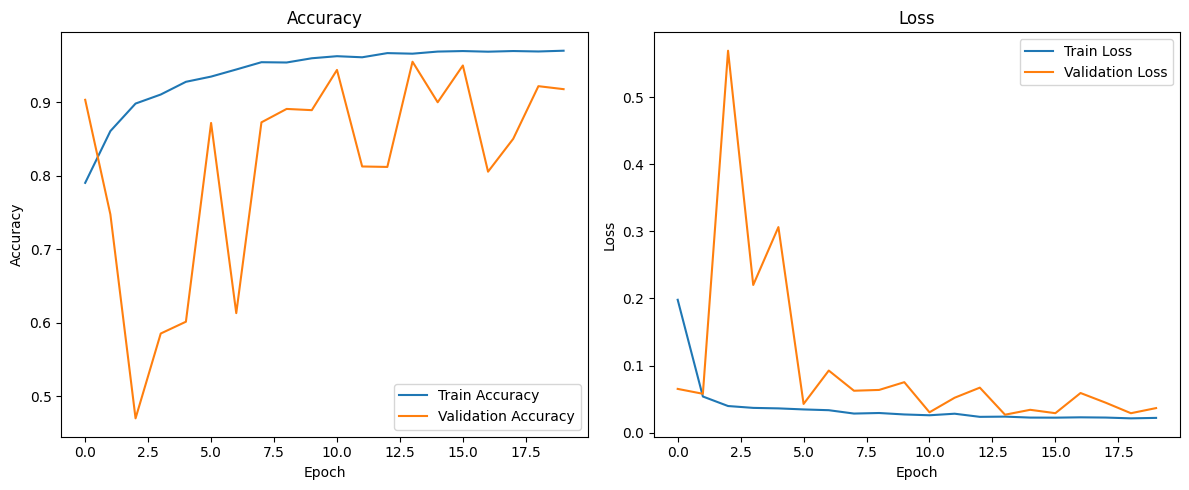

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/01_focal_loss_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.89      0.95      0.92      4800
        open       0.95      0.88      0.91      4800

    accuracy                           0.92      9600
   macro avg       0.92      0.92      0.92      9600
weighted avg       0.92      0.92      0.92      9600



2025-06-13 15:29:11.539675: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 721042227051051557


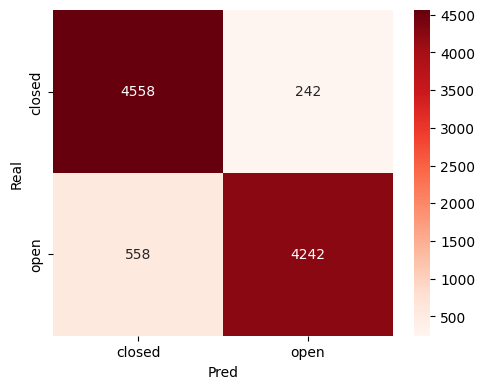

In [8]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)

with open("../../results/reports/01_focal_loss_classification_report.txt", "w") as f:
    f.write(report)

conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/01_focal_loss_confusion_matrix.png")
plt.show()

이 또한 성능이 떨어졌기 때문에, 모델 저장 X